# Finite populations and mutations

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Mutation-Model" data-toc-modified-id="Mutation-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Mutation Model</a></span></li><li><span><a href="#Simulation-run" data-toc-modified-id="Simulation-run-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulation run</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis</a></span></li></ul></div>

## Introduction

We run a simulation for the evolution of a population of fixed size, each individual having equal probability of reproduction, but we now also allow mutations. 

Create populations having
10, 30, 100, 300 and 1000 different individuals. As a probability that a mutation occurs in an individual consider
0.001, 0.003, 0.01, 0.03, 0.1. Simulate dynamics of the population until all individuals of the generation come from
the same ancestor for every population size and for each mutation rate 10 times. Assume that each time a mutation
occurs, it leads to a new “allele”. For every population size and every mutation rate we want to determine:
    
1. The mean number of unique mutations that occurred in the entire phylogenetic tree until all individuals derive
from a single ancestor.


2. The mean number of differences between two random individuals in the final population, i.e., how many
different ‘alleles’ they have.
Do these results match the analytical results that we derived in the lecture? Show it on the plot.

## Imports

In [1]:
# Data manipulation
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Mutation Model

In [1091]:
def genetic_drift(n_initial, mutation_rate, mean_sampling_rate=30):
    """
    Calculates random development of a population of size n_initial with mutations.

    Args:
        n_initial (int): Number of initial individuals in population.
        mutation_rate (float): Mutation Probability for each individual
        mean_sampling_rate (float): How many random sample pairs to estimate difference.

    Returns:
        differences (int): Average number of unique differences
        parents (array): Linking instances in population array
        generations (int): Number of generations until homogenity
        TMRCA (int): Time to Most Recent Common Ancestor
        num_mutations (int): Number of mutations
        unique_mutations (int): Mean number of unique mutations until MRCA

    """

    # Initialise all arrays
    init = np.array(range(n_initial))
    population = []
    parents = []
    mutations = [[0] * n_initial]
    population.append(list(init))
    parents.append(list(init))
    mut_index = 1

    # Generate sequences until homogenity
    while not all([x == init[0] for x in init]):
        rand_int = np.random.randint(0, n_initial, n_initial)
        init[:] = init[rand_int]
        mutation_row = []  # mutations

        # Mutations array
        for x in range(n_initial):
            num = random.random()
            mutation_row.append(int(num <= mutation_rate)*mut_index)
            if num <= mutation_rate:
                mut_index += 1

        mutations.append(mutation_row)
        parents.append(list(rand_int))
        population.append(list(init))

    num_mutations = np.max(mutations)
    generations = len(parents)-1

    # One-hot encoded array of different mutations
    ohe = np.zeros((len(parents), n_initial, num_mutations))

    # For each mutation
    for i in range(num_mutations):
        # Set seed
        seed_row, seed_col = tuple(np.argwhere(np.array(mutations) == i+1)[0])
        ohe[seed_row][seed_col][i] = 1

        # For each child row
        remain_tick = generations-seed_row  # eg 3 ticks === remaining rows
        while remain_tick > 0:
            # For each element
            for child in range(n_initial):  # eg 4 individuals
                # Child mutations same as parents mutation
                par = parents[-remain_tick][child]
                ohe[-remain_tick, child, i] = ohe[-(remain_tick+1)][par][i]
            remain_tick -= 1

    diff = 0
    for s in range(mean_sampling_rate):
        pos1, pos2 = np.random.randint(0, n_initial, 2)
        while pos1 == pos2:
            pos2 = np.random.randint(0, n_initial)
        diff += sum([int(a)
                     for a in np.array(ohe[-1, pos1, :] != ohe[-1, pos2, :])])

    differences = diff/mean_sampling_rate

    # Number of generations, search frame
    current = parents[-1]

    # Iterate back through parents path
    TMRCA, pool = 0, []
    while len(current) > 1:
        # Track each element
        for i in range(len(current)):
            previous = parents[generations-TMRCA][current[i]]
            # If previous in pool --> Common Ancestor
            if previous not in pool:
                pool.append(previous)
        # Update current frame
        current = pool.copy()
        pool.clear()
        # For each row add tick to Time until MRCA
        TMRCA += 1

    tree = np.argwhere(np.array(population[-TMRCA:]) == population[-1][0])
    tree[:, 0] += len(parents)-TMRCA
    unique_mutations = np.sum(
        [np.array(mutations)[tuple(node)] != 0 for node in tree])/len(tree)

    return differences, parents, population, TMRCA, mutations, num_mutations, unique_mutations
#            dif, par, pop, TMRCA, mut, num_mut, uniq = 

## Simulation run

In [1111]:
mut_rates = [0.001, 0.003, 0.01, 0.03, 0.1]
n_initials = [10, 30, 100, 300, 1000]
repetitions = 10
Genetic_Drift_df = np.zeros((len(n_initials), len(mut_rates)))
Genome_length = np.zeros((len(n_initials), len(mut_rates)))

In [ ]:
for n in range(len(n_initials)):
    print(n_initials[n])
    for m in range(len(mut_rates)):
        %store Genetic_Drift_df > drift.txt
        %store Genome_length > length.txt
        for rep in range(repetitions):
            dif, par, pop, TMRCA, mut, num_mut, uniq = genetic_drift(n_initials[n], mut_rates[m])
            Genetic_Drift_df[n][m] += dif/10
            Genome_length[n][m] += num_mut/10

In [1113]:
Genetic_Drift_df

array([[ 0.        ,  0.05      ,  0.05      ,  0.28666667,  0.89333333],
       [ 0.04333333,  0.08      ,  0.22666667,  0.83333333,  3.40333333],
       [ 0.13      ,  0.34333333,  1.33      ,  2.61      , 11.29      ],
       [ 0.35333333,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

## Analysis

In [1116]:
Analytical_df = np.zeros((len(n_initials), len(mut_rates)))
for n in range(len(n_initials)):
    for m in range(len(mut_rates)):
        Analytical_df[n][m] = 2*n_initials[n]*mut_rates[m] #*Genome_length[n][m]

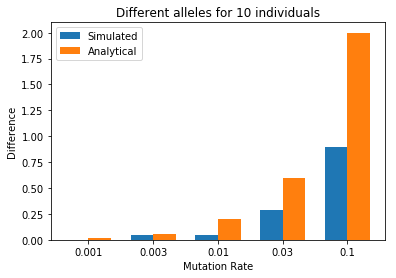

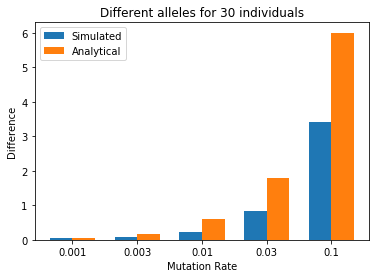

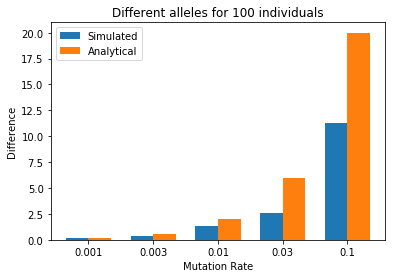

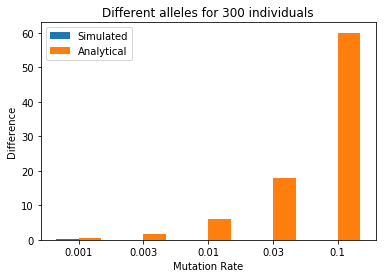

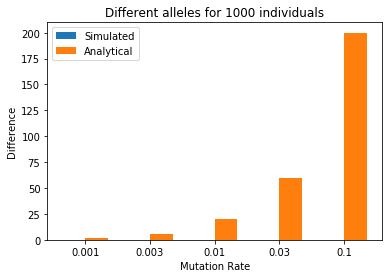

In [1117]:
for n in range(len(n_initials)):
    width = 0.35
    y = np.arange(len(mut_rates))
    plt.bar(y, Genetic_Drift_df[n], width, label='Simulated')
    plt.bar(y+width, Analytical_df[n], width, label='Analytical')
    plt.xticks(y + width / 2, mut_rates)
    plt.title('Different alleles for %d individuals' % n_initials[n])
    plt.ylabel('Difference')
    plt.xlabel('Mutation Rate')
    plt.legend(loc='best')
    plt.show()